In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF

import matplotlib.pyplot as plt
import numpy as np

# Anomaly Detection

Dataset creato con 30000 punti.
Numero di punti anomali: 0


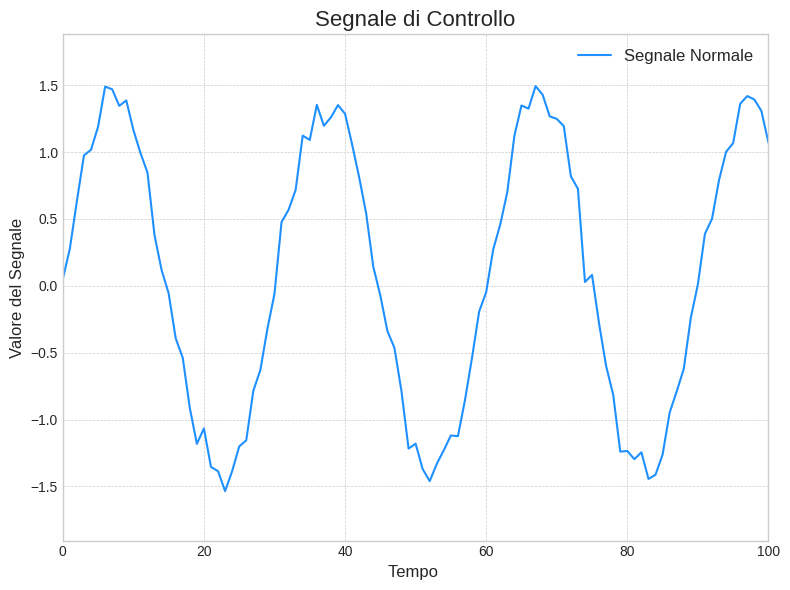

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def crea_dataset(numero_periodi=3000, rumore_std=0.1, n_anomalie=4, seed=42):

    np.random.seed(seed)

    coefficiente = 2 * np.pi / 100

    # Parametri per la periodicità
    frequenza = 5.0
    periodo = 2 * np.pi / frequenza

    # Parametri per il campionamento
    punti_per_periodo = 30

    # Calcola il numero totale di punti e la durata del segnale
    n_punti = int(punti_per_periodo * numero_periodi)
    durata = periodo * numero_periodi

    # Creazione del segnale periodico
    tempo = np.linspace(0, durata, n_punti)
    segnale_base = np.sin(tempo * frequenza) + 0.4 * np.sin(tempo * frequenza)


    # segnale_base = (np.sin(tempo * 5) ) + 0.4* (np.sin(tempo * 5) )

    # Aggiungiamo rumore gaussiano per simulare il rumore del sensore
    rumore = np.random.normal(0, rumore_std, n_punti)
    segnale = segnale_base + rumore

    # Inizializziamo le etichette: 0 = normale, 1 = anomalia
    labels = np.zeros(n_punti, dtype=int)

    tipi_anomalia = ['spike', 'shift', 'ampiezza']
    if n_anomalie != 0:
        punti_per_anomalia = n_punti // n_anomalie

    for i in range(n_anomalie):
        tipo = np.random.choice(tipi_anomalia)

        # Scegliamo una posizione casuale all'interno del segmento dedicato
        start_idx = i * punti_per_anomalia + np.random.randint(50, punti_per_anomalia - 50)

        # Le anomalie dureranno almeno 20 punti
        lunghezza_minima = 10

        if tipo == 'spike':
            # Un picco improvviso, ma esteso per 20 punti, come un colpo o un errore del sensore
            # Ampiezza dello spike molto più grande
            ampiezza_spike = np.random.choice([-1, 1]) * np.random.uniform(5, 8)
            segnale[start_idx : start_idx + lunghezza_minima] += ampiezza_spike
            labels[start_idx : start_idx + lunghezza_minima] = 1

        elif tipo == 'shift':
            # Un offset improvviso, come un cambiamento di carico
            lunghezza = np.random.randint(lunghezza_minima, 60)
            # Ampiezza del shift molto più grande
            ampiezza_shift = np.random.uniform(3.0, 4.0)
            segnale[start_idx : start_idx + lunghezza] += ampiezza_shift
            labels[start_idx : start_idx + lunghezza] = 1

        elif tipo == 'ampiezza':
            # Un cambiamento nell'ampiezza, come un movimento più ampio del previsto
            lunghezza = np.random.randint(lunghezza_minima, 80)
            # Fattore di amplificazione molto più grande
            fattore_amp = np.random.uniform(2.5, 3.5)
            # Amplifichiamo solo la parte periodica, non il rumore
            segnale[start_idx : start_idx + lunghezza] = (
                segnale_base[start_idx : start_idx + lunghezza] * fattore_amp +
                rumore[start_idx : start_idx + lunghezza]
            )
            labels[start_idx : start_idx + lunghezza] = 1

    return segnale, labels

n_punti  = 1000
segnale_controllo, labels = crea_dataset(numero_periodi=n_punti, n_anomalie=0)


print(f"Dataset creato con {len(segnale_controllo)} punti.")
print(f"Numero di punti anomali: {np.sum(labels)}")

# Visualizziamo il risultato per verificarlo
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Troviamo gli indici dei punti anomali per plottarli separatamente
indici_anomali = np.where(labels == 1)[0]

ax.plot(segnale_controllo, label='Segnale Normale', color='dodgerblue', zorder=1)
# ax.scatter(indici_anomali, segnale_controllo[indici_anomali],
#             color='orangered', label='Anomalia Rilevata', zorder=2, s=20)

ax.set_title("Segnale di Controllo", fontsize=16)
ax.set_xlabel("Tempo ", fontsize=12)
ax.set_ylabel("Valore del Segnale", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim([0,100])

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
import snntorch.spikegen as spikegen
from torch.utils.data import DataLoader

class SpikingTimeSeriesDataset(Dataset):
    def __init__(self, segnale, labels, finestra=100, num_steps=50):
        self.segnale = segnale
        self.labels = labels
        self.finestra = finestra
        self.num_steps = num_steps
        self.start_indices = list(range(0, len(segnale) - self.finestra + 1, self.finestra))

    def __len__(self):
        return len(self.start_indices)

    def __getitem__(self, idx):
        start_idx = self.start_indices[idx]

        # Genero la finestra di self.finestra elementi
        x_window = self.segnale[start_idx : start_idx + self.finestra]
        y_labels = self.labels[start_idx : start_idx + self.finestra]

        # Trasformo x_window in un Tensore
        x_tensor = torch.tensor(x_window, dtype=torch.float)

        # Codifico in spike il tensore di input
        # spike_train = spikegen.delta(x_tensor, threshold=0.2, off_spike = True)
        spike_train = spikegen.rate(x_tensor, num_steps = num_steps)

        return spike_train, torch.Tensor(x_window), torch.tensor(y_labels, dtype=torch.float)


scaler = MinMaxScaler()
segnale_controllo, labels = crea_dataset(numero_periodi=n_punti, n_anomalie=0)
data = scaler.fit_transform(segnale_controllo.reshape(-1,1))


num_steps = 50
data = data.reshape(len(segnale_controllo),)
# Crea il dataset di training
finestra_w = 30
dataset_training = SpikingTimeSeriesDataset(
    segnale=data,
    labels=labels,
    finestra=finestra_w,
    num_steps=num_steps
)


train_loader = DataLoader(dataset_training, batch_size=128, shuffle=False)

In [ ]:
for x,x1 , y in train_loader:
  break

test = x[0]

In [ ]:
x.shape

torch.Size([128, 50, 30])

torch.Size([30])


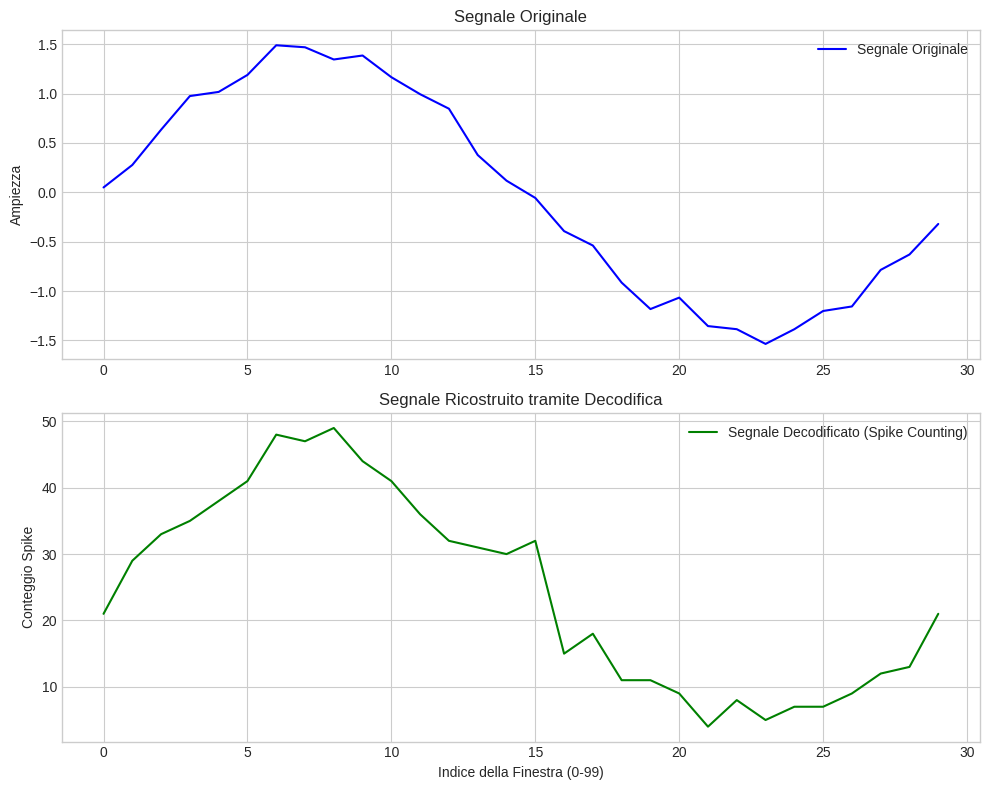

In [ ]:
# output = torch.sum(output_spikes[0], dim=0)
input = torch.sum(test, dim=0)
print(input.shape)

# 4. Visualizzazione con Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Grafico del segnale originale
ax1.plot(segnale_controllo[0:30], color='blue', label='Segnale Originale')
ax1.set_title('Segnale Originale')
ax1.set_ylabel('Ampiezza')
ax1.grid(True)
ax1.legend()

# Grafico del segnale decodificato
ax2.plot(input, color='green', label='Segnale Decodificato (Spike Counting)')
ax2.set_title('Segnale Ricostruito tramite Decodifica')
ax2.set_xlabel('Indice della Finestra (0-99)')
ax2.set_ylabel('Conteggio Spike')
ax2.grid(True)
ax2.legend()


plt.tight_layout()
plt.show()

In [ ]:
# Definizione del Modello SNN

num_inputs = finestra_w
num_hidden = finestra_w//2
# num_steps = finestra_w


class Model(nn.Module):
    def __init__(self,num_inputs,num_hidden,num_outputs,num_steps=25,beta=0.95):
        super().__init__()

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.num_outputs = num_outputs
        self.beta = beta

        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_outputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x[:,step,:])
            # cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=1), torch.stack(mem2_rec, dim=1)

model = Model(num_inputs,num_hidden, num_inputs, num_steps= 50)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device("cuda") if torch.cuda.is_available() else (
         torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))

model.to(device)

num_epochs = 50
global_step = 0

print("Inizio addestramento...")
for epoch in range(num_epochs):

    for i, (spk_in, _, _) in enumerate(train_loader):
        # print(spk_in.shape)
        spk_in = spk_in.to(device)

        spk_out, mem_out = model(spk_in)
        # print(spk_out.shape)
        loss_val = loss_fn(spk_out, spk_in)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        global_step += 1
        # if global_step % 10 == 0:
    print(f"Epoca {epoch+1}/{num_epochs}, Loss: {loss_val.item():.4f}")

print("Addestramento completato.\n")

Inizio addestramento...
Epoca 1/50,, Loss: 0.4593
Epoca 2/50,, Loss: 0.4019
Epoca 3/50,, Loss: 0.3376
Epoca 4/50,, Loss: 0.2981
Epoca 5/50,, Loss: 0.2819
Epoca 6/50,, Loss: 0.2877
Epoca 7/50,, Loss: 0.2896
Epoca 8/50,, Loss: 0.2914
Epoca 9/50,, Loss: 0.2938
Epoca 10/50,, Loss: 0.2917
Epoca 11/50,, Loss: 0.2924
Epoca 12/50,, Loss: 0.2948
Epoca 13/50,, Loss: 0.2909
Epoca 14/50,, Loss: 0.2949
Epoca 15/50,, Loss: 0.2946
Epoca 16/50,, Loss: 0.2911
Epoca 17/50,, Loss: 0.2930
Epoca 18/50,, Loss: 0.2916
Epoca 19/50,, Loss: 0.2950
Epoca 20/50,, Loss: 0.2934
Epoca 21/50,, Loss: 0.2933
Epoca 22/50,, Loss: 0.2942
Epoca 23/50,, Loss: 0.2927
Epoca 24/50,, Loss: 0.2917
Epoca 25/50,, Loss: 0.2934
Epoca 26/50,, Loss: 0.2922
Epoca 27/50,, Loss: 0.2953
Epoca 28/50,, Loss: 0.2941
Epoca 29/50,, Loss: 0.2929
Epoca 30/50,, Loss: 0.2959
Epoca 31/50,, Loss: 0.2973
Epoca 32/50,, Loss: 0.2966
Epoca 33/50,, Loss: 0.2955
Epoca 34/50,, Loss: 0.2957
Epoca 35/50,, Loss: 0.2953
Epoca 36/50,, Loss: 0.2964
Epoca 37/50,,

In [ ]:
for x,x1, y in train_loader:
  break

test = x[0:1]
model.eval()
with torch.no_grad():  # Disabilita il calcolo dei gradienti
    output_spikes,_ = model(test)




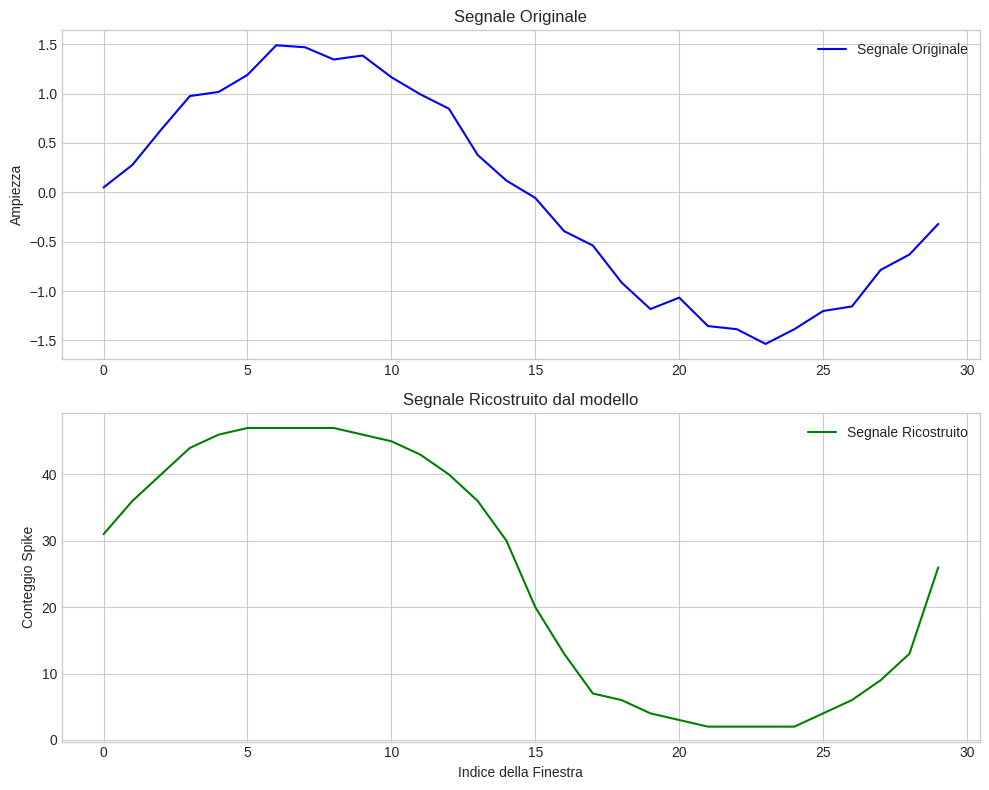

In [ ]:
# output = torch.sum(output_spikes[0], dim=0)
input = torch.sum(test[0], dim=0)
output = torch.sum(output_spikes[0], dim=0)

# 4. Visualizzazione con Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Grafico del segnale originale
ax1.plot(segnale_controllo[0:30], color='blue', label='Segnale Originale')
ax1.set_title('Segnale Originale')
ax1.set_ylabel('Ampiezza')
ax1.grid(True)
ax1.legend()

# Grafico del segnale decodificato
# Nota: L'asse x del segnale decodificato ha la stessa lunghezza del segnale originale (100)
ax2.plot(output, color='green', label='Segnale Ricostruito')
ax2.set_title('Segnale Ricostruito dal modello')
ax2.set_xlabel('Indice della Finestra')
ax2.set_ylabel('Conteggio Spike')
ax2.grid(True)
ax2.legend()


# ax3.plot(output, color='green', label='Segnale Ricostruito')
# ax3.set_title('Segnale Ricostruito dal modello')
# ax3.set_xlabel('Indice della Finestra')
# ax3.set_ylabel('Conteggio Spike')
# ax3.grid(True)
# ax3.legend()


plt.tight_layout()
plt.show()

In [ ]:
lista_inputs = []
lista_labels = []

# Disabilita il calcolo dei gradienti per efficienza
with torch.no_grad():
    # Itera su ogni batch del dataloader
    for inputs,_, labels in train_loader:
        lista_inputs.append(inputs)
        lista_labels.append(labels)

# Concatena i tensori di tutti i batch
full_inputs = torch.cat(lista_inputs, dim=0)
full_labels = torch.cat(lista_labels, dim=0)


In [ ]:
model.eval()
with torch.no_grad():
  spk,_ = model(full_inputs)
mse = torch.nn.MSELoss()
print(f"MSE medio sul training set : {mse(spk,full_inputs):.2f}")
print(f"MSE di soglia per anomalia : {(mse(spk,full_inputs) * 1.2):.2f}")


# print(f"MSE medio sul training set : {mse(torch.mean(spk, dim=1),full_inputs):.2f}")
# print(f"MSE di soglia per anomalia : {(mse(torch.mean(spk, dim=1),full_inputs) * 1.2):.2f}")

MSE medio sul training set : 0.29
MSE di soglia per anomalia : 0.35


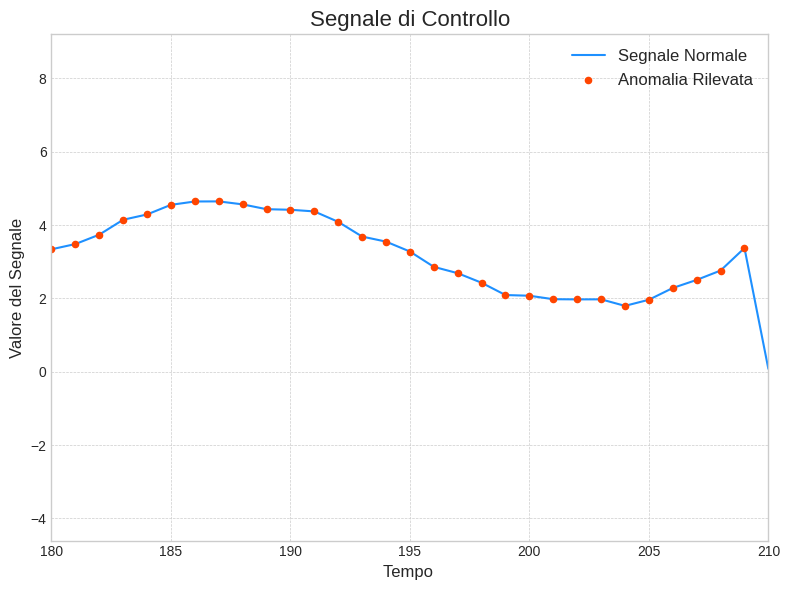

In [ ]:
segnale_controllo, labels = crea_dataset(numero_periodi=100, n_anomalie=10)
data = scaler.transform(segnale_controllo.reshape(-1,1))



data = data.reshape(len(segnale_controllo),)
# Crea il dataset di training
dataset_testing = SpikingTimeSeriesDataset(
    segnale=data,
    labels=labels,
    finestra=finestra_w,
    num_steps=50
)


test_loader = DataLoader(dataset_testing, batch_size=128, shuffle=False)


# Visualizziamo il risultato per verificarlo
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Troviamo gli indici dei punti anomali per plottarli separatamente
indici_anomali = np.where(labels == 1)[0]

ax.plot(segnale_controllo, label='Segnale Normale', color='dodgerblue', zorder=1)
ax.scatter(indici_anomali, segnale_controllo[indici_anomali],
            color='orangered', label='Anomalia Rilevata', zorder=2, s=20)

ax.set_title("Segnale di Controllo", fontsize=16)
ax.set_xlabel("Tempo ", fontsize=12)
ax.set_ylabel("Valore del Segnale", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim([180,210])

plt.tight_layout()
plt.show()

In [ ]:
lista_inputs = []
lista_labels = []
lista_originale = []

# Disabilita il calcolo dei gradienti per efficienza
with torch.no_grad():
    # Itera su ogni batch del dataloader
    for inputs,originale, labels in test_loader:
        lista_inputs.append(inputs)
        lista_originale.append(originale)
        lista_labels.append(labels)

# Concatena i tensori di tutti i batch
full_inputs = torch.cat(lista_inputs, dim=0)
full_originale = torch.cat(lista_originale,dim=0)
full_labels = torch.cat(lista_labels, dim=0)

Errore di ricostruzione della finestra: 0.50


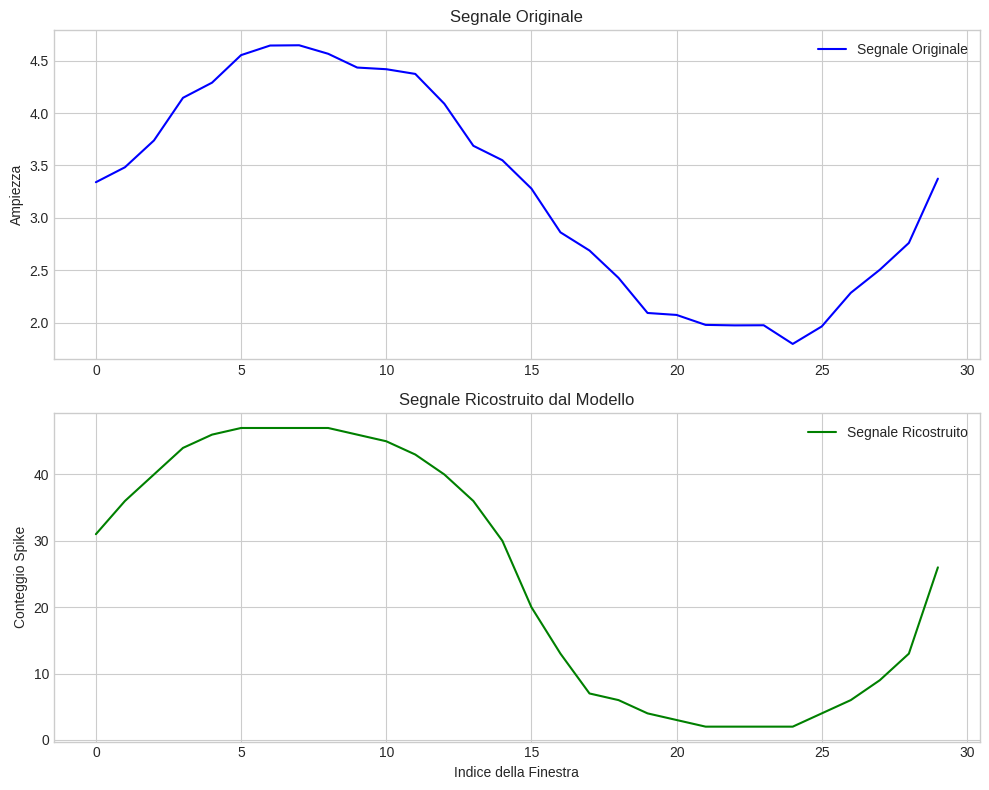

In [ ]:
# output = torch.sum(output_spikes[0], dim=0)

model.eval()
with torch.no_grad():
  spk,_ = model(full_inputs[6].unsqueeze(0))
mse = torch.nn.MSELoss()
# print(mse(spk,full_inputs[6].unsqueeze(0)))

print(f"Errore di ricostruzione della finestra: {mse(spk,full_inputs[6].unsqueeze(0)):.2f}")
input = torch.sum(full_inputs[6], dim=0)
output = torch.sum(spk.squeeze(0), dim=0)

# 4. Visualizzazione con Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Grafico del segnale originale
ax1.plot(segnale_controllo[30*(6):30*(6+1)], color='blue', label='Segnale Originale')
ax1.set_title('Segnale Originale')
ax1.set_ylabel('Ampiezza')
ax1.grid(True)
ax1.legend()



ax2.plot(output, color='green', label='Segnale Ricostruito')
ax2.set_title('Segnale Ricostruito dal Modello')
ax2.set_xlabel('Indice della Finestra')
ax2.set_ylabel('Conteggio Spike')
ax2.grid(True)
ax2.legend()



plt.tight_layout()
plt.show()